## Yield Spread model

This notebook implements a model to predict new yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 January 2023 to 1 March 2023. The test set is the month of March 2023. 

Last Update: Lables are computed using realtime ficc ycl

Note: Change NUM_FEATURES to 6 if you want to train with treasury spreads

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay



from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-07-13 00:03:22.047758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 00:03:22.060937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 00:03:22.061594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [5]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [6]:
storage_client = storage.Client()

Declaring hyper-parameters

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 2
NUM_FEATURES = 6

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [8]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [9]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('automated_training/processed_data.pkl') as f:
# with fs.open('ficc_training_data_latest/processed_data_2023-05-06-10:25.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 1min 58s, sys: 40 s, total: 2min 38s
Wall time: 4min 57s


#### Date range for data

In [10]:
data.trade_date.max()

Timestamp('2023-07-11 00:00:00')

In [11]:
data.trade_date.min()

Timestamp('2022-05-02 00:00:00')

In [12]:
print(f'Restricting history to {SEQUENCE_LENGTH} trades')
data.trade_history = data.trade_history.apply(lambda x: x[:SEQUENCE_LENGTH])
data.target_attention_features = data.target_attention_features.apply(lambda x:x[:SEQUENCE_LENGTH])

Restricting history to 2 trades


In [13]:
data.trade_history.iloc[0].shape

(2, 6)

In [14]:
data.target_attention_features.iloc[0].shape

(1, 3)

In [15]:
len(data)

11597407

In [16]:
# data = data.sort_values(by='trade_datetime', ascending=True).copy()

### Creating features from trade history

This implementation is an adaption of Charles's implementation 

In [17]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [18]:
%%time
temp = data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)

CPU times: user 3min 10s, sys: 32.3 s, total: 3min 42s
Wall time: 7min 8s


In [19]:
YS_COLS = get_trade_history_columns()

In [20]:
data[YS_COLS] = pd.DataFrame(temp.tolist(), index=data.index)

Adding trade history features to PREDICTORS list

In [21]:
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [22]:
len(data)

11597407

In [23]:
%%time
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))

CPU times: user 57.9 s, sys: 11.1 s, total: 1min 8s
Wall time: 1min 16s


In [24]:
data = data.dropna(subset=['trade_history_sum'])

In [25]:
len(data)

11597407

For the purpose of plotting, not used in training

In [26]:
data.purpose_sub_class.fillna(0, inplace=True)

Creating new ys label

In [27]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']
# data['new_ys'] = data['yield'] - data['new_real_time_ficc_ycl']

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [28]:
# PREDICTORS

In [29]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'new_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called',]
#                      'new_real_time_ficc_ycl']
                      #,'maturity_description_code']

In [30]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]

Checking for missing data and NaN values

In [31]:
len(processed_data)

11597407

In [32]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [33]:
processed_data.dropna(inplace=True, subset=PREDICTORS)

Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
<li>Callable less than a year in the future
<li>Maturity less than a year in the future and more than 30 years in the future
</ul>


In [34]:
len(processed_data)

11597407

In [35]:
processed_data = processed_data[(processed_data.days_to_call == 0) | (processed_data.days_to_call > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_refund == 0) | (processed_data.days_to_refund > np.log10(400))]
processed_data = processed_data[(processed_data.days_to_maturity == 0) | (processed_data.days_to_maturity > np.log10(400))]
processed_data = processed_data[processed_data.days_to_maturity < np.log10(30000)]

In [36]:
len(processed_data)

10768011

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [37]:
categorical_feature_values = {'purpose_class' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                                                 47, 48, 49, 50, 51, 52, 53],
                              'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                         'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                              'trade_type' : ['D', 'S', 'P'],
                              'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                         'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                         'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                         'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                         'VT', 'WA', 'WI', 'WV', 'WY'] }

In [38]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


#### Adding target trade features

In [39]:
trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
def target_trade_processing_for_attention(row):
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (1,1))

In [40]:
processed_data['target_attention_features'] = processed_data.parallel_apply(target_trade_processing_for_attention, axis = 1)

#### Splitting the data into train and test sets

In [41]:
train_dataframe = processed_data[(processed_data.trade_date < '08-01-2023')]

In [42]:
test_dataframe = processed_data[(processed_data.trade_date >= '03-01-2023') & (processed_data.trade_date <= '03-30-2023') ]

In [43]:
len(train_dataframe)

10768011

In [44]:
train_dataframe.trade_date.max()

Timestamp('2023-07-11 00:00:00')

In [45]:
len(test_dataframe)

670030

In [46]:
test_dataframe.trade_date.min()

Timestamp('2023-03-01 00:00:00')

##### Converting data into format suitable for the model

In [47]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [48]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.new_ys

CPU times: user 1min 16s, sys: 1.93 s, total: 1min 18s
Wall time: 1min 18s


In [49]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.new_ys

CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.72 s


In [50]:
x_train[0].shape

(10768011, 2, 6)

In [51]:
x_test[2].shape

(670030, 48)

## LightGBM

In [64]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY ] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features'])#,'yield_spread'])
    return df

In [65]:
trainlabel = train_dataframe.new_ys
testlabel = test_dataframe.new_ys

In [66]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [67]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [68]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 1h 11min 15s, sys: 17.5 s, total: 1h 11min 32s
Wall time: 2min 26s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [69]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(test_dataframe[PREDICTORS]))
delta = testlabel - gbt_pred
print(delta.mean(), delta.abs().mean())

0.12299579060957835 7.160923579555406
CPU times: user 1min 11s, sys: 768 ms, total: 1min 11s
Wall time: 6.45 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

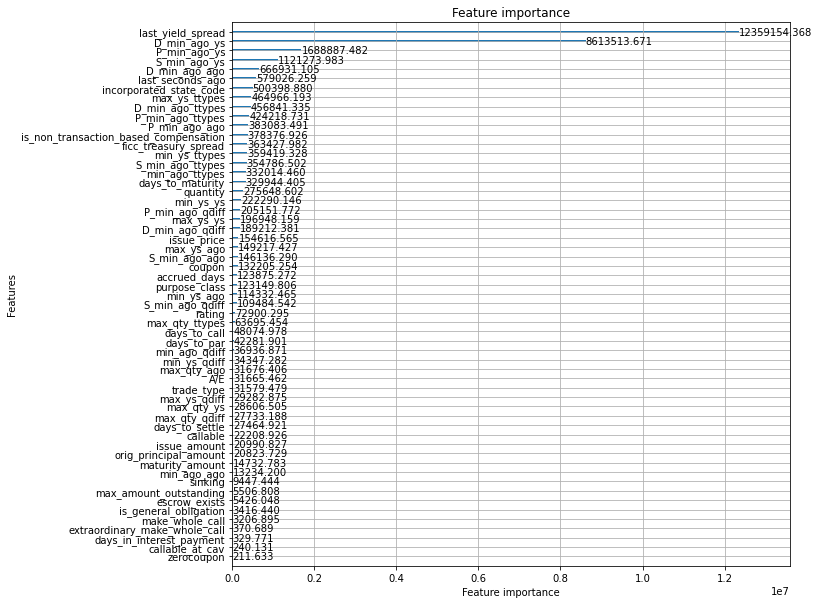

In [70]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [52]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

2023-07-13 00:26:26.126698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 00:26:26.130495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 00:26:26.131295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 00:26:26.131940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [53]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [54]:
tf.keras.utils.set_random_seed(10)

#### Implementation of the model

We define an attention mechanism to weigh the importance of the target trade with respect to the output of the second LSTM layer. The attention mechanism first calculates the dot product between the LSTM output and the target trade using the Dot layer. The axes=\[2, 2\] means that we want to perform a dot product between the last axis of lstm ouput and the last axis of target trade sequence. The result is passed through a softmax activation function using the Activation layer to obtain the attention weights. The attention weights indicate the relative importance of each lstm hidden state with the target trade. Finally, the attention weights are used to calculate a context vector as a weighted sum of the traget trade using another Dot layer.

In [55]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(1, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM'))

lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                activation='tanh',
                                                input_shape=(SEQUENCE_LENGTH,50),
                                                return_sequences = True,
                                                name='LSTM_2'))



features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_layer_2(features)


attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
attention = layers.Activation('softmax')(attention)

context_vector = layers.Dot(axes=[1, 1])([features, attention])
context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


trade_history_output = layers.Dense(100, 
                                    activation='relu')(context_vector)

####################################################

############## REFERENCE DATA MODEL ################
# global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                   output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                   input_length= 1,
                                                                   name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='relu')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

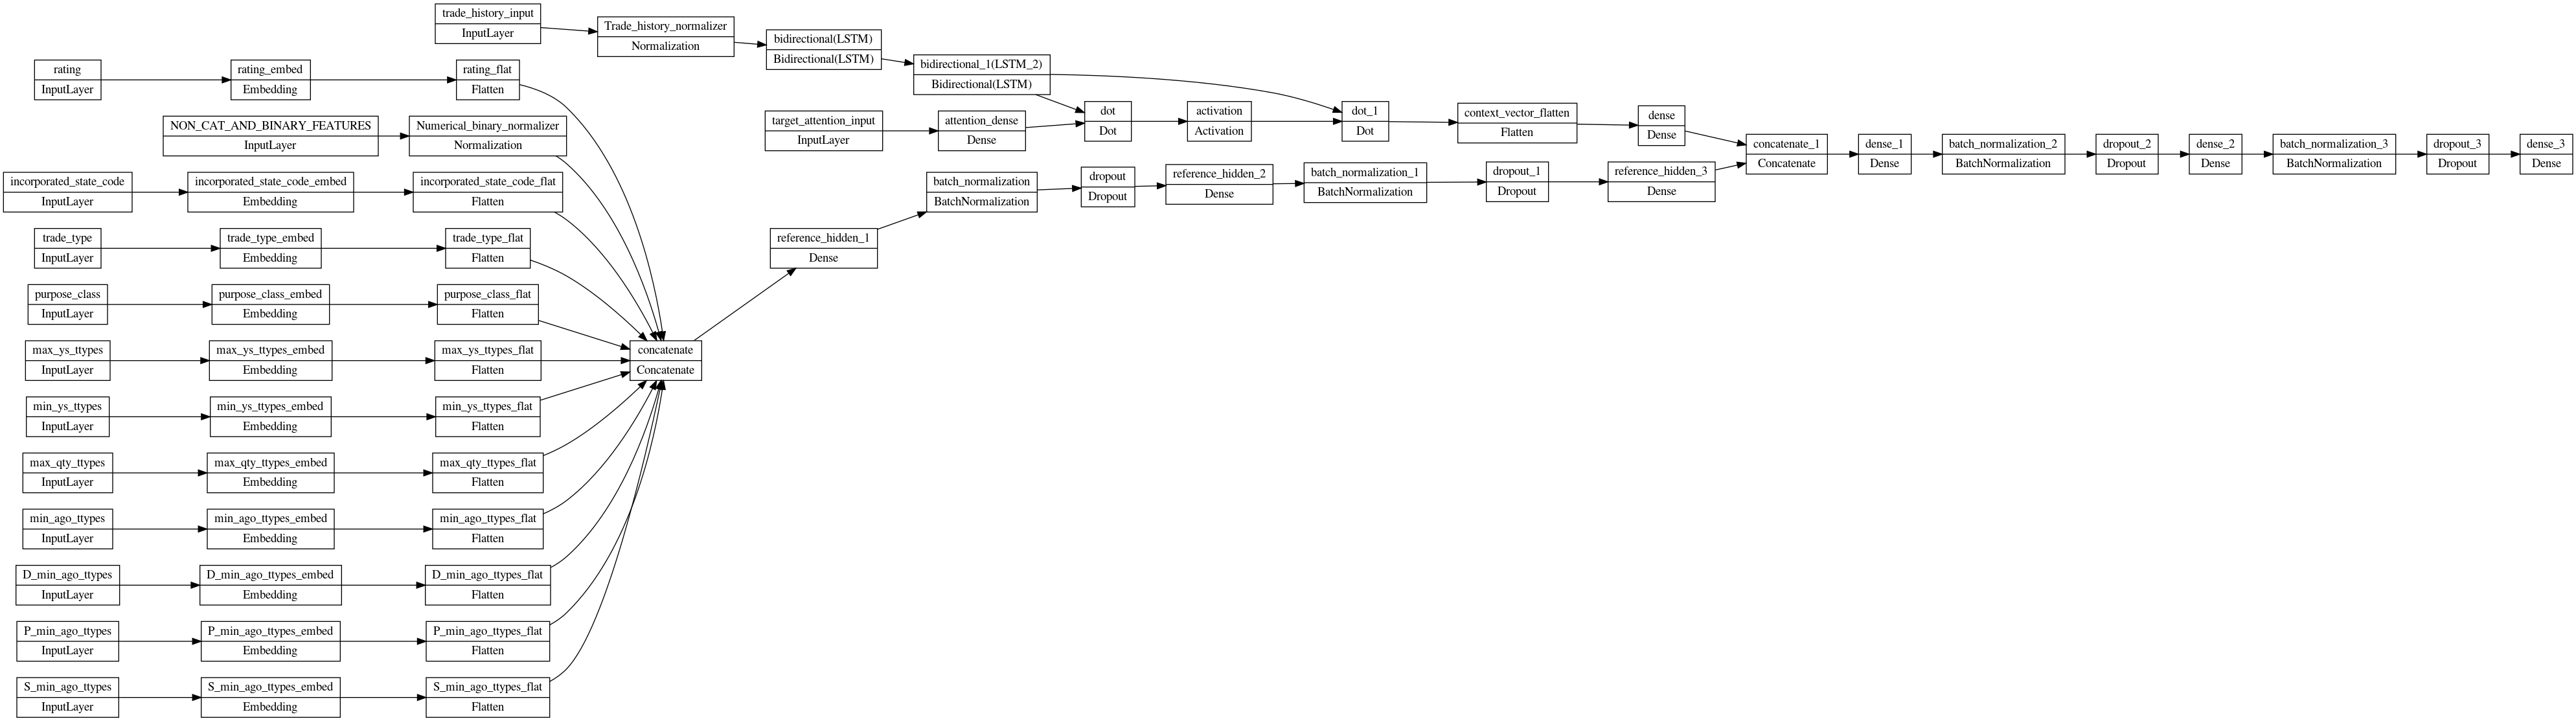

In [57]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [58]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [59]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [60]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

In [61]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100


2023-07-13 00:27:03.045840: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-07-13 00:27:05.337495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


9689/9692 [============================>.] - ETA: 0s - loss: 22.4387

2023-07-13 00:29:26.181580: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


9692/9692 [==============================] - 155s 15ms/step - loss: 22.4355 - val_loss: 8.9796
Epoch 2/100
9692/9692 [==============================] - 142s 15ms/step - loss: 8.4894 - val_loss: 8.7473
Epoch 3/100
9692/9692 [==============================] - 142s 15ms/step - loss: 8.1363 - val_loss: 8.7483
Epoch 4/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.9418 - val_loss: 8.5683
Epoch 5/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.8147 - val_loss: 8.3875
Epoch 6/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.7158 - val_loss: 8.2849
Epoch 7/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.6440 - val_loss: 8.3438
Epoch 8/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.5906 - val_loss: 8.4892
Epoch 9/100
9692/9692 [==============================] - 142s 15ms/step - loss: 7.5394 - val_loss: 8.3589
Epoch 10/100
9692/9692 [==============================] -

#### Plotting train vs validation loss

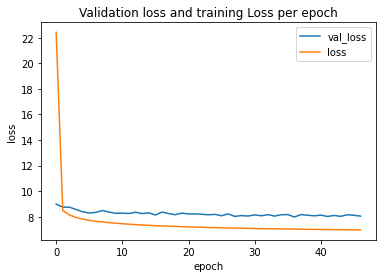

In [62]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [63]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders.pkl")

print("Saving and uploading model")
model.save(f"saved_model_{file_timestamp}")
import shutil
shutil.make_archive(f"model_july_12", 'zip', f"saved_model_{file_timestamp}")
upload_data(storage_client, 'ahmad_data', f"model_july_12.zip")

file time stamp : 2023-07-13-02-17
Saving encoders and uploading encoders
File encoders.pkl uploaded to ahmad_data.
Saving and uploading model


2023-07-13 02:17:13.488761: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model_2023-07-13-02-17/assets


INFO:tensorflow:Assets written to: saved_model_2023-07-13-02-17/assets


File model_july_12.zip uploaded to ahmad_data.


#### Gigaflops for one epoch of training

In [64]:
avg_time = np.mean(time_callback.times)

In [65]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

255.9550947452041


### Test accuracy on the entire test set

In [66]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

2023-07-13 02:17:30.552427: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [67]:
test_dataframe['absolute_delta'] = np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)

In [68]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 6.405


In [69]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 6.405


#### Accuracy on a daily basis for dealer dealer trades

In [79]:
for d in [d for d in pd.date_range(start="04/01/2023",end="04/30/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.new_ys - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [80]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]#& (test_dataframe.coupon == 5)]

In [81]:
# true_mid = test_dataframe[ (test_dataframe.last_seconds_ago > 60*60*24*30) & 
#                            (test_dataframe.quantity >= np.log10(100000))]

In [82]:
len(true_mid)

9334

In [83]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 86.4 ms, sys: 11 ms, total: 97.4 ms
Wall time: 96.9 ms


In [84]:
%%time
mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

10/10 [==============================] - 0s 5ms/step - loss: 4.0795
Test MAE: 4.08
CPU times: user 171 ms, sys: 23.2 ms, total: 194 ms
Wall time: 132 ms


### Plotting new ys vs predicted ys

In [85]:
processed_data[(processed_data.new_ys > 1000) & (processed_data.trade_date < '2023-04-30') & (processed_data.trade_date >= '2023-04-01')][['cusip','rtrs_control_number','new_ys','trade_datetime']]

,cusip,rtrs_control_number,new_ys,trade_datetime
58879,084538HS9,2023042704325900,2955.790511,2023-04-27 12:11:08
64484,084538HS9,2023042702838600,2982.750937,2023-04-27 11:16:51
64485,084538HS9,2023042702809000,2996.050937,2023-04-27 11:16:51
73819,83704DAN6,2023041911542800,1708.604796,2023-04-19 16:47:40
73854,83704DAN6,2023041911528100,1704.504796,2023-04-19 16:46:40
73923,83704DAN6,2023041911532400,1694.630264,2023-04-19 16:43:54
100673,64542PDQ5,2023041904101600,1346.866156,2023-04-19 11:51:50
100674,64542PDQ5,2023041904091600,1357.866156,2023-04-19 11:51:50
149479,084538HS9,2023041801966300,3125.969645,2023-04-18 10:31:30
149480,084538HS9,2023041801966100,3125.969645,2023-04-18 10:31:30


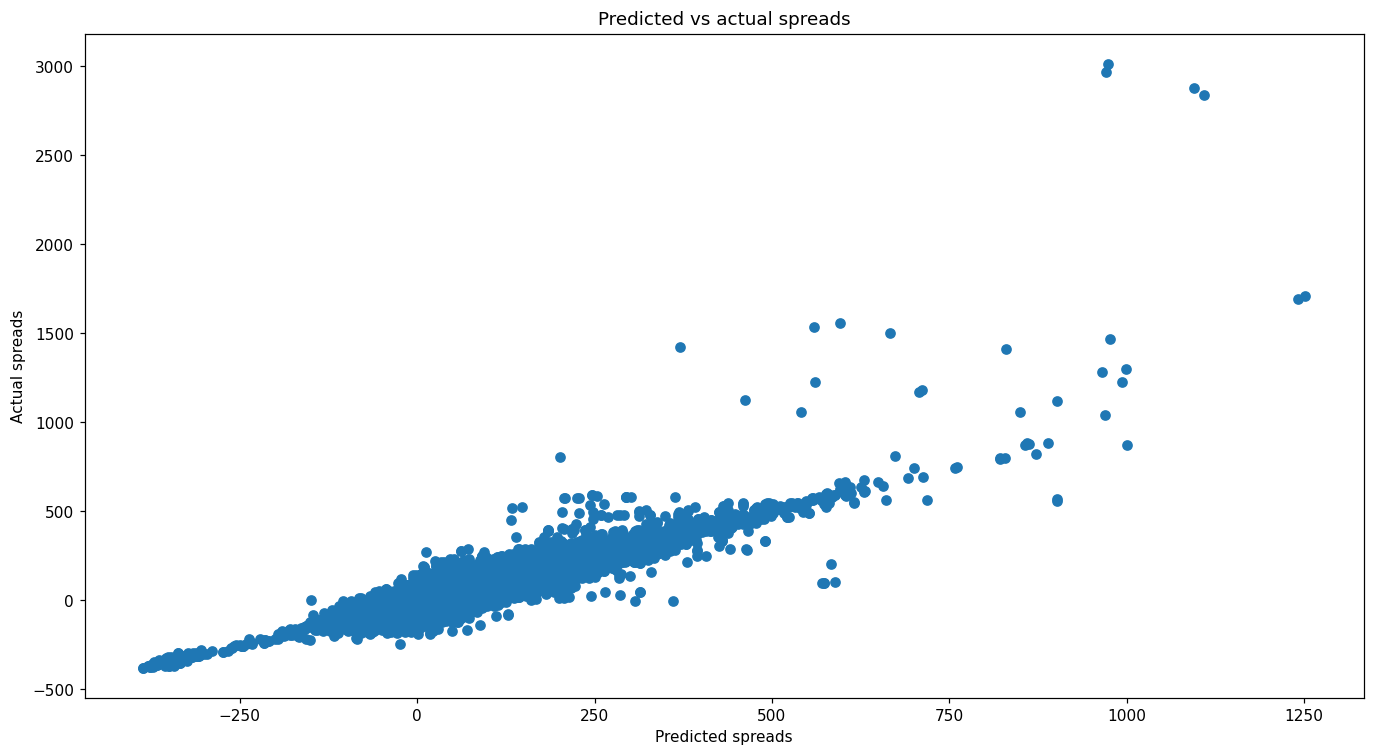

In [86]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

In [87]:
test_dataframe['delta_ys'] = test_dataframe['new_ys'] - test_dataframe['predicted_ys']

In [88]:
test_dataframe[(test_dataframe.delta_ys > 500)][['cusip','rtrs_control_number','trade_date','yield','new_ficc_ycl','dollar_price','last_yield_spread','new_ys','predicted_ys','delta_ys','calc_date']]

,cusip,rtrs_control_number,trade_date,yield,new_ficc_ycl,dollar_price,last_yield_spread,new_ys,predicted_ys,delta_ys,calc_date
16758,08451PAE1,2023052507346800,2023-05-25,3177.0,334.371441,57.000,2876.428559,2842.628559,1109.027588,1733.600971,2025-11-01
16817,084538HY6,2023052507325800,2023-05-25,1453.3,325.615303,56.750,395.404204,1127.684697,461.620911,666.063787,2031-02-01
16936,08451PAE1,2023052507308200,2023-05-25,3210.8,330.996298,56.625,742.56279,2879.803702,1094.998169,1784.805533,2025-11-01
88281,084538HW0,2023051601347700,2023-05-16,1689.1,275.071923,57.500,1425.928077,1414.028077,830.374939,583.653138,2029-02-01
88666,084538HZ3,2023051601239400,2023-05-16,1350.5,289.685131,57.200,481.148679,1060.814869,541.261963,519.552906,2032-02-01
88796,084538HW0,2023051601194500,2023-05-16,1701.0,276.532784,57.200,270.501955,1424.467216,370.876892,1053.590324,2029-02-01
37148,084538HX8,2023051501831700,2023-05-15,1506.0,277.352464,58.410,485.12837,1228.647536,559.967834,668.679702,2030-02-01
38414,816459QX2,2023051501724800,2023-05-15,1087.3,283.697083,78.835,234.417661,803.602917,201.847275,601.755642,2026-07-01
62514,08451PAD3,2023051102771000,2023-05-11,3278.3,308.552363,69.625,942.490222,2969.747637,970.972839,1998.774798,2024-11-01
62550,08451PAD3,2023051102769200,2023-05-11,3322.6,308.552363,69.250,942.490222,3014.047637,973.746338,2040.301299,2024-11-01


In [89]:
test_dataframe[['trade_date','new_ys','predicted_ys','delta_ys']]

,trade_date,new_ys,predicted_ys,delta_ys
0,2023-05-30,98.214755,77.734184,20.480570
1,2023-05-30,69.614755,68.830070,0.784684
4,2023-05-30,32.693191,39.595245,-6.902055
5,2023-05-30,57.093191,59.164497,-2.071307
6,2023-05-30,-57.877522,-7.332487,-50.545035
...,...,...,...,...
40561,2023-05-01,22.220632,18.971310,3.249323
40564,2023-05-01,17.252217,16.581562,0.670655
40565,2023-05-01,17.252217,18.180410,-0.928194
40568,2023-05-01,170.854393,169.514481,1.339913
